## Ly$\alpha$ Attenuation

This notebook calculates the lyman-alpha attenuation

In [145]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy import units as u
from twentyonecmFAST import load_binary_data
import tqdm
import glob
import os

In [188]:
def binary_ish_to_npy(files):
    for f in files:
        print (f)
        halo = np.loadtxt(f)
        np.save(f + '.npy', halo)

In [133]:
def tau_s(z_s):
    """
    
    """
    return 6.45e5 * (cosmo.Ob0 * cosmo.h / 0.03) * (cosmo.Om0 / 0.3) ** -0.5 * ((1 + z_s) / 10)

def helper(x):
    """
    """
    return (x ** 4.5 / (1. - x) + 9 / 7 * x ** 3.5 + 
            9. / 5. * x ** 2.5 + 3 * x ** 1.5 + 9 * x ** 0.5 - 
            4.5 * np.log((1 + x ** 0.5) / (1 - x ** 0.5)))

def tau_lya(halo_pos, xH, z, z_reion = 6., dim = 256, width = 200 * u.Mpc):
    """
    xH: (np.array, int)
        Average neutral fraction
        
    z: float
        Source redshift
        
    halo_file: float
        asdf
        
    Returns:
    -------
    
    """
    D = rand_average_bubble_size(halo_pos, xH, dim = dim, width = width)
    z_obs = z + hand_wavy_redshift(z, D)
    h_diff = (helper((1 + z) / (1 + z_obs)) - helper((1 + z_reion) / (1 + z_obs)))
    return np.mean(xH) * tau_s(z) * (2.02e-8 / np.pi) * ((1 + z) / (1 + z_obs)) ** 1.5 * h_diff

def hand_wavy_redshift(z, D = 6.6 * u.Mpc):
    """
    """
    return (cosmo.H(z) * D / const.c).to(u.dimensionless_unscaled)


def bubble_size(pos, xH):
    """
    
    Return the ionized bubble size in voxels
    
    Parameters:
    ----------
    
    pos : tuple, np.array
        LAE halo positions
        
    xH : np.array
        Neutral fraction cube
        
    """
    try:
        return np.abs(pos[2] - np.array(np.nonzero(xH[pos[0], pos[1], ]))).min()
    
    except:
        return -1

    
def average_bubble_size(halo_pos, xH, dim = 256., width = 200. * u.Mpc):
    """
    Calculates the mean of the whole sample
    """
    pix = 0
    count = 0
    for i in tqdm.tqdm(range(halo_pos.shape[0]),
                       desc="Calculating Mean Bubble Size",
                       unit="halo",
                       total=halo_pos.shape[0]):
        size = bubble_size(halo_pos[i, :], xH)
        if size > 0:
            pix += size
            count += 1
    return (pix / count) * (width / dim)

def rand_average_bubble_size(halo_pos, xH, dim = 256., width = 200. * u.Mpc):
    """
    Randomly selects ~1% of the population to take the mean
    """
    pix = 0
    count = 0
    s = halo_pos.shape[0]
    idx = np.random.choice(np.arange(s), replace = False, size = int(s / 100.))
    pos = halo_pos[idx, :]

    for i in tqdm.tqdm(range(pos.shape[0]),
                       desc="Calculating Mean Bubble Size",
                       unit="halo",
                       total=pos.shape[0]):
        size = bubble_size(pos[i, :], xH)
        if size > 0:
            pix += size
            count += 1
    return (pix / count) * (width / dim)

In [196]:
xHs = glob.glob('../../data/xH*')
xHs.sort()

h_path = glob.glob('../../data/halos*.npy')
h_path.sort()

In [206]:
atten = []
zs = []
xhs = []

for i in np.arange(len(h_path)):
    xH = load_binary_data(xHs[i])
    xH = np.reshape(xH, (256, 256, 256))
    xhs.append(np.mean(xH))
    halos = np.load(h_path[i])
    halo_pos = (halos[:, 1:] * 256).astype(int)
    z = float(os.path.basename(h_path[i]).split('_')[1][1:])
    zs.append(z)
    atten.append(np.exp(-tau_lya(halo_pos, xH, z)))

Calculating Mean Bubble Size: 100%|██████████| 20523/20523 [00:00<00:00, 47098.42halo/s]


In [209]:
np.savez('attenuation.npz', zs = zs, tau = atten, xH = xhs)

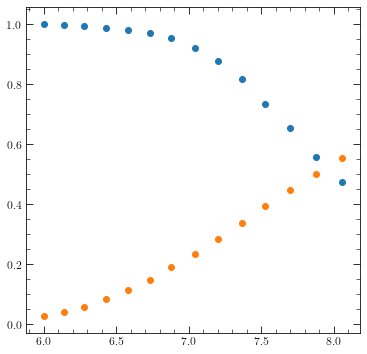

In [210]:
plt.figure(figsize = (6,6))
plt.scatter(zs, atten)
plt.scatter(zs, xhs)
plt.show()

In [1]:
import pickle

with open ('21cmSense_objs/hera_sense_6_0.pkl', 'rb') as pkl:
    sensitivity = pickle.load(pkl)

In [2]:
sensitivity.calculate_sensitivity_2d?